In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import hbar
from sympy import Matrix
from scipy.integrate import solve_ivp
from arc.alkali_atom_functions import AlkaliAtom
import arc
import qutip as qtp

always left is the 3x3 system (targhet) and right is the 2x2 system (control)

In [3]:
def sigma3x3(a, b): # |a><b| operator
    basis_a = [
        np.array([[1],[0],[0]]),
        np.array([[0],[1],[0]]),
        np.array([[0],[0],[1]])
    ]
    basis_b = [
        np.array([1,0,0]),
        np.array([0,1,0]),
        np.array([0,0,1])
    ]
    return np.kron(basis_a[a],basis_b[b])

def sigma2x2(a, b): # |a><b| operator
    basis_a = [
        np.array([[1],[0]]),
        np.array([[0],[1]])
    ]
    basis_b = [
        np.array([1,0]),
        np.array([0,1])
    ]
    return np.kron(basis_a[a],basis_b[b])

def H_targhet(Omega_p, Omega_, Delta, delta):
    dressed_H = np.array([[0, Omega_p/2, 0],[Omega_p/2, -Delta, Omega_/2],[0, Omega_/2, -delta]])
    return dressed_H

def H_control(Omega_c, delta):
    dressed_H = np.array([[0, Omega_c/2],[Omega_c/2, -delta]])
    return dressed_H

def H_int(V_fac): # V_fac = C_6 / r^6
    return V_fac*np.kron(sigma3x3(2,2), sigma2x2(1,1))

In [20]:
t = 100
steps = 1000
times = np.linspace(0.0, t, steps)
psi0 = qtp.Qobj(np.kron(sigma3x3(0,0), sigma2x2(0,0)))

delta = -15
Om_p = 0.5
Om_c = 5
Om_ = 5
V_f = -15
Gamma_i = 1
Gamma_ry = 0.001
Gamma_B = 1
def_i = 0
def_ry = 0

S_minus_i = Gamma_i**(1/2)*np.array([[0,1,0],[0,0,0],[0,0,0]])
S_minus_ry = Gamma_ry**(1/2)*np.array([[0,0,0],[0,0,1],[0,0,0]])
S_minus_ry2x2 = Gamma_B**(1/2)*np.array([[0,1],[0,0]])
Jump_ops = [
    qtp.Qobj(np.kron(S_minus_i, np.eye(2))), 
    qtp.Qobj(np.kron(S_minus_ry, np.eye(2))), 
    qtp.Qobj(np.kron(np.eye(3), S_minus_ry2x2)),
    qtp.Qobj(np.kron(np.eye(3), def_ry * sigma2x2(1,1)))
    ]

H_0 = qtp.Qobj(np.kron(H_targhet(Om_p, Om_, 0, 0), np.eye(2)) + np.kron(np.eye(3), H_control(Om_c, delta)))
H = H_0 + H_int(V_f)

In [21]:
result = qtp.mesolve(H, psi0, times, c_ops = Jump_ops)

In [22]:
evo = [np.array(result.states[i]) for i in range(steps)]
p_trace_resA = {}
p_trace_resB = {}
labels_A = ["ground","intermediate","rydberg"]
labels_B = ["ground","rydberg"]
for l, label in enumerate(labels_A):
    p_trace_resA[label] = [np.trace(np.dot(evo[i],np.kron(sigma3x3(l,l), np.eye(2)))) for i in range(steps)]
for l, label in enumerate(labels_B):
    p_trace_resB[label] = [np.trace(np.dot(evo[i],np.kron(np.eye(3),sigma2x2(l,l)))) for i in range(steps)]

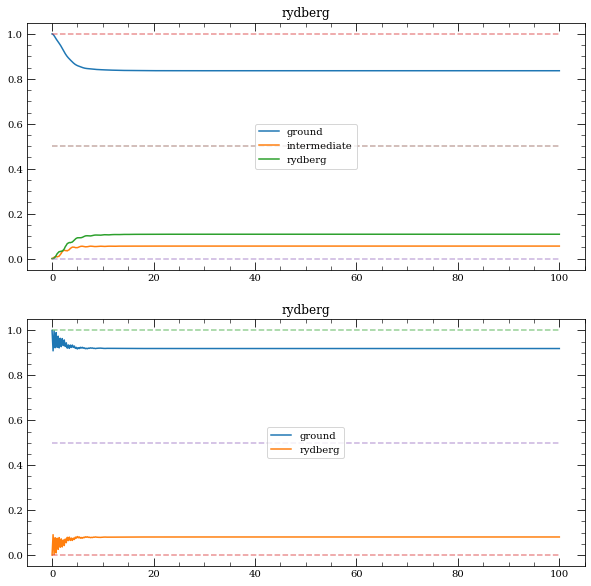

In [23]:
plt.figure(figsize=(10,10))

plt.subplot(211)
for i, label in enumerate(labels_A):
    plt.plot(times, p_trace_resA[label], label=label)
plt.plot([0,times[-1]],[1,1],"--", alpha=0.5)
plt.plot([0,times[-1]],[0,0],"--", alpha=0.5)
plt.plot([0,times[-1]],[1/2,1/2],"--", alpha=0.5)
plt.ylim([-0.05,1.05])
plt.title(label)
plt.legend()

plt.subplot(212)
for i, label in enumerate(labels_B):
    plt.plot(times, p_trace_resB[label], label=label)
plt.plot([0,times[-1]],[1,1],"--", alpha=0.5)
plt.plot([0,times[-1]],[0,0],"--", alpha=0.5)
plt.plot([0,times[-1]],[1/2,1/2],"--", alpha=0.5)
plt.ylim([-0.05,1.05])
plt.title(label)
plt.legend()

plt.show()

In [14]:
N_points = 100
deltas = np.linspace(-45,10,N_points)
results = []
for delta in deltas:
    H_0 = qtp.Qobj(np.kron(H_targhet(Om_p, Om_, 0, 0), np.eye(2)) + np.kron(np.eye(3), H_control(Om_c, delta)))
    H = H_0 + H_int(V_f)
    result = qtp.mesolve(H, psi0, times, c_ops = Jump_ops)
    results.append(result.states[-1])

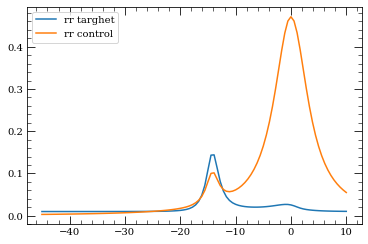

In [15]:
rho_33A = [np.trace(np.dot(results[i],np.kron(sigma3x3(2,2), np.eye(2)))) for i in range(N_points)]
rho_33B = [np.trace(np.dot(results[i],np.kron(np.eye(3),sigma2x2(1,1)))) for i in range(N_points)]
plt.plot(deltas, rho_33A, label = "rr targhet")
plt.plot(deltas, rho_33B, label = "rr control")
#plt.plot([-15,-15],[0,max(rho_33A)],"--",c="gray",alpha=0.5)
plt.legend()
plt.show()

In [9]:
82*2*np.pi

515.221195188726